# LSTM

In [1]:
from numpy import ones, unique
from sklearn.model_selection import StratifiedGroupKFold

from src.common.helpers import read_dataframe
from src.rnn.data import WindowGenerator


2026-01-21 16:01:14.952614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769007674.976357  194020 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769007674.983298  194020 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-21 16:01:15.008379: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


loaded labels


In [2]:
all_features = read_dataframe("data/df/rnn/cvs_features.pkl")

feature_placeholder = ones(shape=(all_features.shape[0]))
groups = all_features["group"]
labels = all_features["label"]

In [3]:
fold_num = 1 # range 1 - 10
sgkf1 = StratifiedGroupKFold(n_splits=10, shuffle=False)
#for i, (train_temp, test_index) in enumerate(sgkf1.split(feature_placeholder, labels, groups)):
train_temp, test_index = list(sgkf1.split(feature_placeholder, labels, groups))[fold_num-1]

sgkf2 = StratifiedGroupKFold(n_splits=10, shuffle=False)
train_index, val_index = list(sgkf2.split(train_temp, labels[train_temp], groups[train_temp]))[fold_num-1]
train_index = train_temp[train_index]
val_index = train_temp[val_index]

train_groups = unique(groups[train_index])
val_groups = unique(groups[val_index])
test_groups = unique(groups[test_index])

print(f"Fold {fold_num}:")
print(f"  Train: groups={train_groups}")
print(f"  Val:  groups={val_groups}")
print(f"  Test:  groups={test_groups}")

Fold 1:
  Train: groups=[  0   1   2   3   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  25  26  27  28  29  30  31  32  33  34  37  39  40
  41  42  43  44  46  47  48  50  51  52  53  54  55  56  57  58  59  61
  62  63  64  65  67  68  69  70  71  72  73  74  75  76  77  80  81  82
  83  87  88  89  90  91  93  95  96  97  98  99 101 102 104 106 107 108
 109 110 111 113 114 115 116 117 118 119 120 121 122 125 126 127 128 129
 131 133 134 135 136 137 138 139 142 144 146 148 149 151 153 154 155 156
 157 158 159 160 161 163 164 165 167 168 169 170 172 173 174 175 176 177
 178 180 181 182 183 184 186 187 188 189 190 192 193 194 195 196 197 198
 199 200 201 202 204 205 206 209 210 211 212 213 214 216 217 219 220 221
 222 223 224 225 226 227 228 229]
  Val:  groups=[  4  24  35  49  60  79  84  86  92 103 123 140 145 152 171 191 203 208
 215 218]
  Test:  groups=[ 36  38  45  66  78  85  94 100 105 112 124 130 132 141 143 147 150 162
 166 179 185 207]


In [4]:
w1 = WindowGenerator(input_width=5, label_width=1, shift=1, data=all_features, 
    train_groups=train_groups, val_groups=val_groups, test_groups=test_groups)
print(w1)

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]


In [ ]:
w1.inspect_fold_split()

In [ ]:
w1.plot()

In [5]:
from src.rnn.architecture import RnnArch
from src.rnn.model import Rnn, RnnConstructorArgs, RnnModelInitializeArgs, RnnTrainArgs


In [6]:
rnn = Rnn(args=RnnConstructorArgs(
    name="arch1",
    model_initialize_args=RnnModelInitializeArgs(
        model_arch=RnnArch.ARCH1
    )
))
rnn.initialize_model()

loading the model 'arch1' from 'data/runs/rnn/arch1/train2/models/epoch_02__val_accuracy_0.9597.keras'


I0000 00:00:1769007687.065961  194020 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20937 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:21:00.0, compute capability: 7.5


In [ ]:
rnn._get_best_model_path()

In [ ]:
rnn.train_model(args=RnnTrainArgs(
    window_generator=w1,
    epochs=5))

In [7]:
rnn.model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 128)            │       128,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 7)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 386,711 (1.48 MB)

 Trainable params: 128,903 (503.53 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 257,808 (1007.07 KB)

All shapes are: (batch, time, features)
Window shape: (3, 6, 121)
Inputs shape: (3, 5, 121)
Labels shape: (3, 1, 7)


I0000 00:00:1769007708.287021  194328 cuda_dnn.cc:529] Loaded cuDNN version 90300
/projects/climbing-technique-detector/src/rnn/data.py:258: UserWarning: Legend does not support handles for Text instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


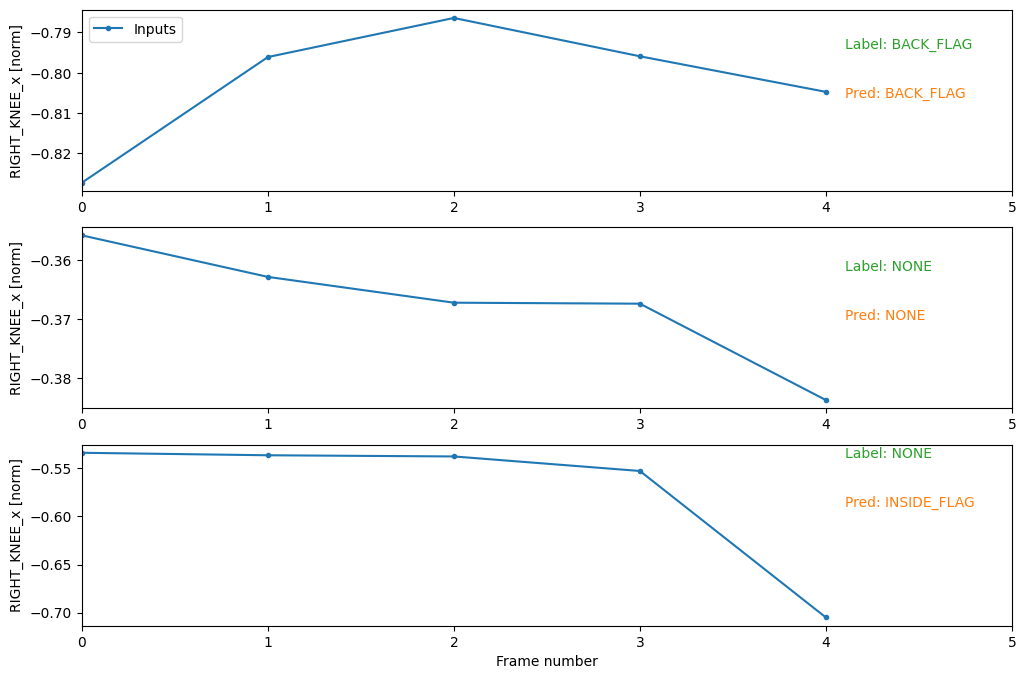

In [8]:
w1.plot(rnn.model, plot_col="RIGHT_KNEE_x")